In [1]:
#!pip install timm
#!pip install einops
#!pip install spectral
#!pip install plotly
#!pip install pandas
#!pip install seaborn
#!pip install scikit-image
#!pip install opencv-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from einops import rearrange

import torch.nn.init as init

In [3]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
# 地物类别
class_num = 9
X = sio.loadmat('Dioni.mat')['Dioni']
y = sio.loadmat('Dioni_gt.mat')['Dioni_gt']

# 用于测试样本的比例
test_ratio = 0.99
# 每个像素周围提取 patch 的尺寸
patch_size = 1
# 使用 PCA 降维，得到主成分的数
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_cube, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_cube.shape)
print('Data cube y shape: ', y.shape)

X = rearrange(X_cube, 'b h n d -> b (n h) d')
X = X.squeeze(1)
print('Data cube X shape: ', X.shape)
print('Data cube y shape: ', y.shape)
print("X_pca shape:",X_pca.shape)


Hyperspectral data shape:  (250, 1376, 176)
Label shape:  (250, 1376)

... ... PCA tranformation ... ...
Data shape after PCA:  (250, 1376, 30)

... ... create data cubes ... ...
Data cube X shape:  (20024, 1, 1, 30)
Data cube y shape:  (20024,)
Data cube X shape:  (20024, 30)
Data cube y shape:  (20024,)
X_pca shape: (250, 1376, 30)


In [5]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=11, stratify=y)

svm = SVC(C=100, kernel='rbf', cache_size=10*1024)
svm.fit(X_train, y_train)
ypred = svm.predict(X_test)

classification = classification_report(y_test, ypred, digits=4)
print(classification)

def output_metric():
    matrix = confusion_matrix(y_test, ypred)
    OA, AA_mean, Kappa, AA = cal_results(matrix)
    return OA, AA_mean, Kappa, AA
#-------------------------------------------------------------------------------
def cal_results(matrix):
    shape = np.shape(matrix)
    number = 0
    sum = 0
    AA = np.zeros([shape[0]], dtype=float)
    for i in range(shape[0]):
        number += matrix[i, i]
        AA[i] = matrix[i, i] / np.sum(matrix[i, :])
        sum += np.sum(matrix[i, :]) * np.sum(matrix[:, i])
    OA = number / np.sum(matrix)
    AA_mean = np.mean(AA)
    pe = sum / (np.sum(matrix) ** 2)
    Kappa = (OA - pe) / (1 - pe)
    return OA, AA_mean, Kappa, AA

OA, AA_mean, Kappa, AA = output_metric()
print("OA:{} | AA_mean:{} | Kappa:{}".format(OA,AA_mean,Kappa,))

              precision    recall  f1-score   support

         0.0     0.7590    0.6757    0.7150      1249
         1.0     1.0000    0.0347    0.0670       202
         2.0     0.9091    0.4112    0.5663       608
         3.0     1.0000    0.0336    0.0649       149
         4.0     0.8201    0.8491    0.8344      1750
         6.0     1.0000    0.6190    0.7647       357
         8.0     0.8540    0.8510    0.8525      4985
         9.0     0.7657    0.9033    0.8288      6310
        10.0     0.5579    0.6154    0.5853      1737
        11.0     0.9712    0.4148    0.5813       487
        12.0     0.9956    0.9937    0.9947      1596
        13.0     1.0000    0.6701    0.8024       394

    accuracy                         0.8008     19824
   macro avg     0.8861    0.5893    0.6381     19824
weighted avg     0.8151    0.8008    0.7908     19824

OA:0.8008474576271186 | AA_mean:0.5893004243933732 | Kappa:0.747836694185916


... ... row  0  handling ... ...
... ... row  100  handling ... ...
... ... row  200  handling ... ...


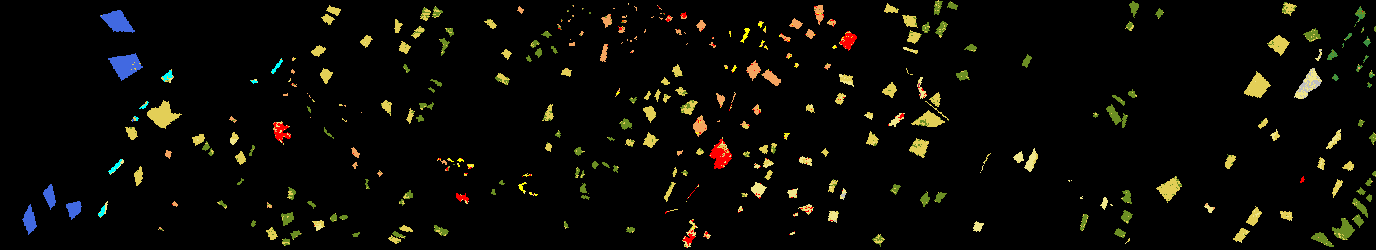

In [6]:
# load the original image
#print(X_pca.shape)
y = sio.loadmat('Dioni_gt.mat')['Dioni_gt']
#print(y.shape)
patch_size = 1
height = y.shape[0]
width = y.shape[1]
# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X_pca[i:i+patch_size, j:j+patch_size, :]
            #print(image_patch.shape)
            image_patch =  rearrange(image_patch, 'b h n -> (b h) n')
            prediction = svm.predict(image_patch)                              
            outputs[i][j] = prediction+1
    if i % 100 == 0:
        print('... ... row ', i, ' handling ... ...')

from PIL import Image
label = np.zeros([outputs.shape[0], outputs.shape[1], 3])
for i in range(outputs.shape[1]):
  for j in range(outputs.shape[0]):
    if outputs[j,i]==0:
      label[j,i,0]=0
      label[j,i,1]=0
      label[j,i,2]=0
    if outputs[j,i]==1:#Dense Urban Fabric--红色
      label[j,i,0]=255
      label[j,i,1]=0
      label[j,i,2]=0
    if outputs[j,i]==2:#Mineral Extraction Sites--栗红
      label[j,i,0]=176
      label[j,i,1]=48
      label[j,i,2]=96
    if outputs[j,i]==3:#Non Irrigated Arable Land--黄色
      label[j,i,0]=255
      label[j,i,1]=255
      label[j,i,2]=0
    if outputs[j,i]==4:#FruitTrees--橙色
      label[j,i,0]=255
      label[j,i,1]=97
      label[j,i,2]=0
    if outputs[j,i]==5:#Olive Groves--沙棕色
      label[j,i,0]=244
      label[j,i,1]=164
      label[j,i,2]=96
    if outputs[j,i]==6:#Broad-Leaved Forest--翠绿色
      label[j,i,0]=0
      label[j,i,1]=201
      label[j,i,2]=87
    if outputs[j,i]==7:#Coniferous Forest--钴绿色
      label[j,i,0]=61
      label[j,i,1]=145
      label[j,i,2]=64
    if outputs[j,i]==8:#Mxed Forest--紫色
      label[j,i,0]=160
      label[j,i,1]=32
      label[j,i,2]=240
    if outputs[j,i]==9:#Dense Sderophyllous Vegetation--草绿色
      label[j,i,0]=107
      label[j,i,1]=142
      label[j,i,2]=35
    if outputs[j,i]==10:#Spaece Sderophyllous Vegetation--香蕉色
      label[j,i,0]=227
      label[j,i,1]=207
      label[j,i,2]=87
    if outputs[j,i]==11:#Spaecely Vegetation Areas--黄褐色
      label[j,i,0]=240
      label[j,i,1]=230
      label[j,i,2]=140
    if outputs[j,i]==12:#Rocks and Snad--灰色
      label[j,i,0]=192
      label[j,i,1]=192
      label[j,i,2]=192
    if outputs[j,i]==13:#Water--蓝色
      label[j,i,0]=65
      label[j,i,1]=105
      label[j,i,2]=225
    if outputs[j,i]==14:#Coastal Water--青色
      label[j,i,0]=0
      label[j,i,1]=255
      label[j,i,2]=255
path="outputs_img/HyRANK/"
label = label.astype(int)
image=Image.fromarray(label.astype('uint8'))
image.show()
image.save(path+"HyRANK_rf.jpg")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)

classification = classification_report(y_test, ypred, digits=4)
print(classification)

def output_metric():
    matrix = confusion_matrix(y_test, ypred)
    OA, AA_mean, Kappa, AA = cal_results(matrix)
    return OA, AA_mean, Kappa, AA
#-------------------------------------------------------------------------------
def cal_results(matrix):
    shape = np.shape(matrix)
    number = 0
    sum = 0
    AA = np.zeros([shape[0]], dtype=float)
    for i in range(shape[0]):
        number += matrix[i, i]
        AA[i] = matrix[i, i] / np.sum(matrix[i, :])
        sum += np.sum(matrix[i, :]) * np.sum(matrix[:, i])
    OA = number / np.sum(matrix)
    AA_mean = np.mean(AA)
    pe = sum / (np.sum(matrix) ** 2)
    Kappa = (OA - pe) / (1 - pe)
    return OA, AA_mean, Kappa, AA

OA, AA_mean, Kappa, AA = output_metric()
print("OA:{} | AA_mean:{} | Kappa:{}".format(OA,AA_mean,Kappa,))

In [ ]:
# load the original image
#print(X_pca.shape)
y = sio.loadmat('trento_data.mat')['ground']
#print(y.shape)
patch_size = 1
height = y.shape[0]
width = y.shape[1]
# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X_pca[i:i+patch_size, j:j+patch_size, :]
            #print(image_patch.shape)
            image_patch =  rearrange(image_patch, 'b h n -> (b h) n')
            prediction = rf.predict(image_patch)                              
            outputs[i][j] = prediction+1
    if i % 100 == 0:
        print('... ... row ', i, ' handling ... ...')

from PIL import Image
label = np.zeros([outputs.shape[0], outputs.shape[1], 3])
for i in range(outputs.shape[1]):
  for j in range(outputs.shape[0]):
    if outputs[j,i]==0:
      label[j,i,0]=0
      label[j,i,1]=0
      label[j,i,2]=0
    if outputs[j,i]==1:#appleTrees--深蓝色
      label[j,i,0]=25
      label[j,i,1]=25
      label[j,i,2]=112
    if outputs[j,i]==2:#budding--蓝色
      label[j,i,0]=0
      label[j,i,1]=0
      label[j,i,2]=255
    if outputs[j,i]==3:#ground--浅绿
      label[j,i,0]=124
      label[j,i,1]=252
      label[j,i,2]=0
    if outputs[j,i]==4:#wood--黄色
      label[j,i,0]=255
      label[j,i,1]=255
      label[j,i,2]=0
    if outputs[j,i]==5:#vinetard--亮红
      label[j,i,0]=255
      label[j,i,1]=0
      label[j,i,2]=2
    if outputs[j,i]==6:#road--暗红色
      label[j,i,0]=178
      label[j,i,1]=34
      label[j,i,2]=34

path="outputs_img/trento/"
label = label.astype(int)
image=Image.fromarray(label.astype('uint8'))
image.show()
image.save(path+"trento_rf.jpg")

In [ ]:
y = sio.loadmat('trento_data.mat')['ground']
s=0
for i in range(height):
    for j in range(width):
        if y[i,j] == outputs[i,j] != 0:
            
            s+=1
print(s)
print(float(s/30214))